# Rao-blackwellized particle filter for Kalman filter


References
* [inference_test.py](https://github.com/probml/dynamax/blob/main/dynamax/slds/inference_test.py) in probml/dynamax
* Section 13.4.2 in PML Book 2
* Murphy, Kevin, and Stuart Russell. "Rao-Blackwellised particle filtering for dynamic Bayesian networks." Sequential Monte Carlo methods in practice. New York, NY: Springer New York, 2001. 499-515.

In [1]:
import jax
import chex
import einops
import distrax
import seaborn as sns
import jax.numpy as jnp
import matplotlib.pyplot as plt
from functools import partial

In [2]:
%config InlineBackend.figure_format = "retina"

sns.set_palette("colorblind")
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["font.size"] = 12
# plt.rcParams["figure.figsize"] = (7.2, 4.0)
plt.rcParams["figure.figsize"] = (7.2, 3.0)

jnp.set_printoptions(linewidth=200)

In [3]:
plt.rcParams["text.usetex"] = True

## Model definitions

In [4]:
def draw_state(state, key, config):
    """
    Simulate one step of a system that evolves as
                A z_{t-1} + Bk + eps,
    where eps ~ N(0, Q).
    
    Parameters
    ----------
    val: tuple (int, jnp.array)
        (latent value of system, state value of system).
    params: RBPFParamsDiscrete
    key: PRNGKey
    """
    key_regime, key_latent, key_obs = jax.random.split(key, 3)
    probabilities = config.transition_matrix_regime[state.regime, :]
    logits = jnp.log(probabilities)
    regime_new = jax.random.categorical(key, logits)
    

    latent_new = config.transition_matrix_latent @ state.latent + config.drift[regime_new, :]
    latent_new = jax.random.multivariate_normal(key_latent, latent_new, config.dynamics_covariance)
    obs_new = jax.random.multivariate_normal(key_obs, config.projection_matrix @ latent_new, config.observation_covariance)

    state = state.replace(
        latent=latent_new,
        regime=regime_new
    )
    
    return state, (regime_new, latent_new, obs_new)

## Config

In [5]:
@chex.dataclass
class SSMConfig:
    transition_matrix_regime: chex.Array
    transition_matrix_latent: chex.Array # F
    projection_matrix: chex.Array # H
    dynamics_covariance: chex.Array # Q
    observation_covariance: chex.Array # R
    drift: chex.Array # B


@chex.dataclass
class RBPFKFState:
    latent: chex.Array
    regime: chex.Array

In [926]:
num_states = 3
num_particles = 10
state_dim = 4
emission_dim = 4

TT = 0.01
A = jnp.array([[1, TT, 0, 0],
            [0, 1, 0, 0],
            [0, 0, 1, TT],
            [0, 0, 0, 1]])


B1 = jnp.array([0, 0, 0, 0])
B2 = jnp.array([-1.225, -0.35, 1.225, 0.35])
B3 = jnp.array([1.225, 0.35,  -1.225,  -0.35])
B = jnp.stack([B1, B2, B3], axis=0)

Q = 2.0 * jnp.eye(4)

# Only observe position
R = jnp.diag(jnp.array([2, 2])) * 20
H = jnp.eye(4)[jnp.array([0,2])]

# Only observe one dimension
# R = jnp.diag(jnp.array([2])) * 20
# H = jnp.eye(4)[jnp.array([0])]

p_stay = 0.99
p_transition = (1 - p_stay) / 2
transition_matrix = jnp.array([
    [p_stay, p_transition, p_transition],
    [p_transition, p_stay, p_transition],
    [p_transition, p_transition, p_stay],
])
log_transition_matrix = jnp.log(transition_matrix)

In [927]:
config = SSMConfig(
    transition_matrix_regime=transition_matrix,
    transition_matrix_latent=A,
    projection_matrix=H,
    dynamics_covariance=Q,
    observation_covariance=R,
    drift=B
)

latent_init = jnp.zeros(4)
regime_init = 1
state_init = RBPFKFState(regime=regime_init, latent=latent_init)

In [935]:
key = jax.random.PRNGKey(31415)
key_sample, key_train = jax.random.split(key)

n_steps = 3000
keys = jax.random.split(key_sample, n_steps)

In [936]:
_step = partial(draw_state, config=config)
state_last, (hist_regime, hist_latent, hist_path) = jax.lax.scan(_step, state_init, keys)

In [937]:
colors = [sns.color_palette()[i] for i in hist_regime]

Text(0, 0.5, 'y-coord')

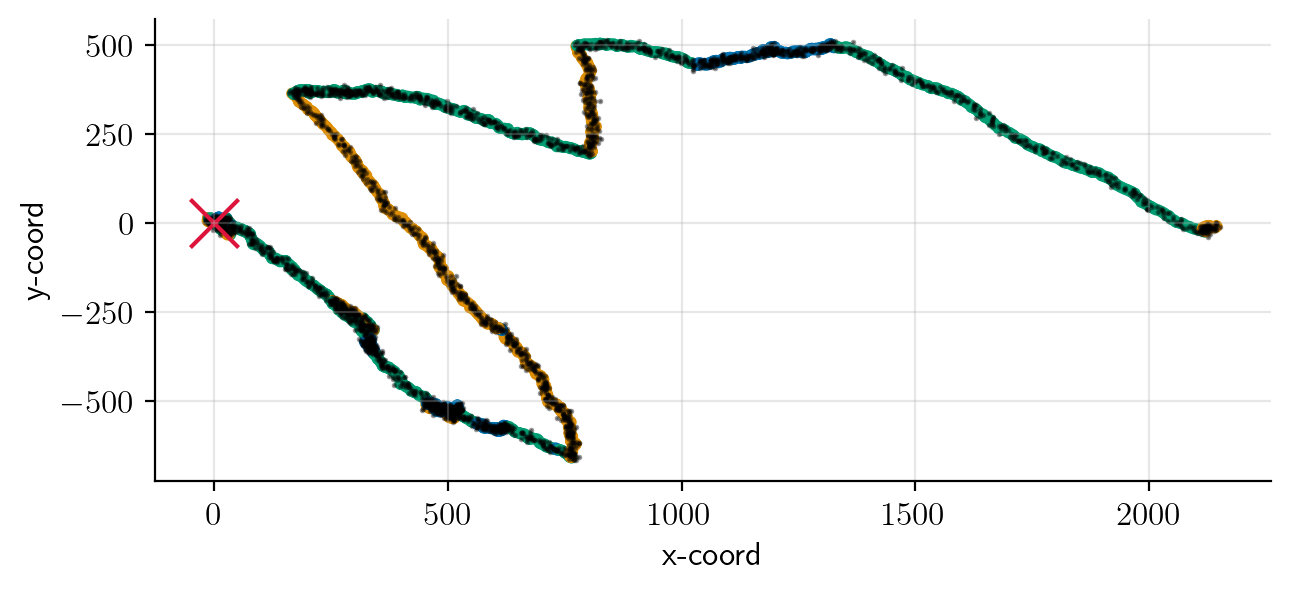

In [938]:
plt.scatter(hist_latent[:, 0], hist_latent[:, 2], c=colors, s=10)
plt.scatter(hist_path[:, 0], hist_path[:, 1], c="black", s=1, alpha=0.4)
plt.grid(alpha=0.3)
plt.scatter(0,0, c="crimson", marker="x", s=300)
plt.xlabel("x-coord")
plt.ylabel("y-coord")

In [939]:
steps = jnp.arange(n_steps)

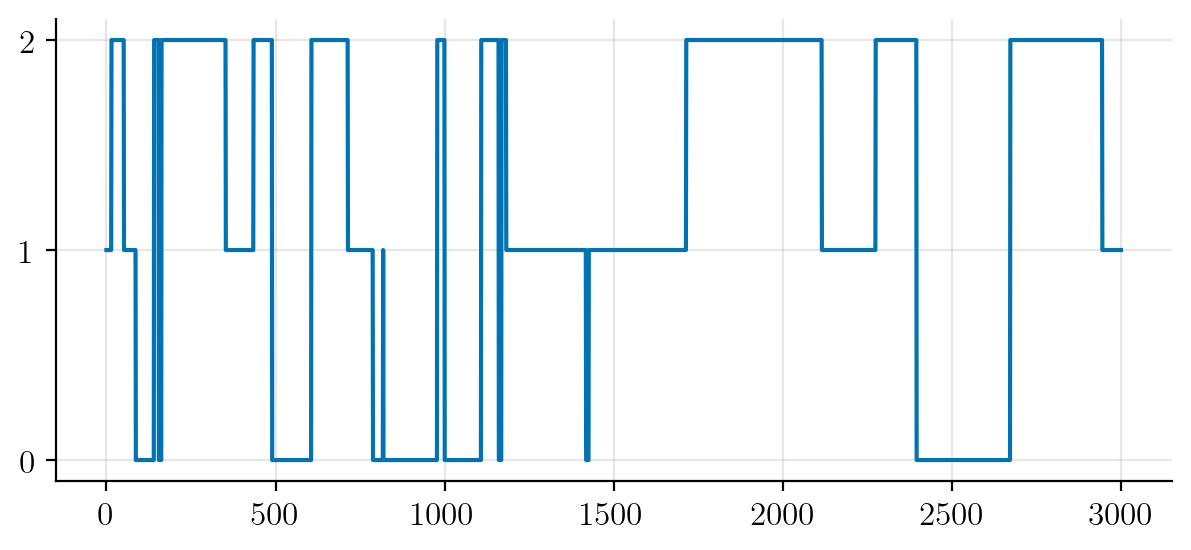

In [940]:
plt.plot(hist_regime)
plt.yticks([0, 1, 2])
plt.grid(alpha=0.3)

## The Kalman filter

In [941]:
@chex.dataclass
class KFConfig:
    H: jax.Array
    F: jax.Array
    Q: jax.Array
    R: jax.Array


@chex.dataclass
class KFState:
    mean: jax.Array
    cov: jax.Array
    regime: jax.Array # KF config

    @staticmethod
    def init(key, mean, cov, n_particles, n_configs):
        means = einops.repeat(mean, "m -> s m", s=n_particles)
        covs = einops.repeat(cov, "i j -> s i j", s=n_particles)
        regimes = jax.random.choice(key, n_configs, (n_particles,)) # uniform sample over configs
        
        return KFState(
            mean=means, 
            cov=covs,
            regime=regimes,
        )


def kf_step(y, B, bel, cfg):
    """
    Update belief and compute log-posterior-predictive
    """
    # Predict step
    mean_pred = cfg.F @ bel.mean + B
    cov_pred = cfg.F @ bel.cov @ cfg.F.T + cfg.Q

    # Innovation, variance, and Kalman gain
    yhat = cfg.H @ mean_pred
    err = y - yhat
    St = cfg.H @ cov_pred @ cfg.H.T + cfg.R
    Kt = jnp.linalg.solve(St, cfg.H @ cov_pred).T

    # Update step
    Kcov = jnp.eye(len(bel.mean)) - Kt @ cfg.H
    mean_update = mean_pred + Kt @ err
    cov_update = Kcov @ cov_pred @ Kcov.T + Kt @ cfg.R @ Kt.T

    bel = bel.replace(
        mean=mean_update,
        cov=cov_update
    )

    log_pp = distrax.MultivariateNormalFullCovariance(yhat, St).log_prob(y)

    return bel, log_pp


vkf_step_all = jax.vmap(kf_step, in_axes=(None, 0, 0, None))
vkf_step_B = jax.vmap(kf_step, in_axes=(None, 0, None, None))

In [942]:
config = KFConfig(
    H=H,
    F=A,
    Q=Q,
    R=R
)

# Run in parallel and average

In [943]:
key_init, key_eval = jax.random.split(key_train)
n_particles = 200
n_regimes = 3

In [944]:
def step(bel, y, cfg):
    bel_update, log_pp = vkf_step_all(y, B, bel, cfg)

    weights = log_pp / log_pp.sum()
    mean_avg = (bel_update.mean * weights[:, None]).sum(axis=0)
    
    mean_regime = (bel_update.regime * weights).sum(axis=0)
    
    return bel_update, (weights, mean_regime)

In [945]:
mean_init = jnp.zeros(4)
cov_init = jnp.eye(4) * 1.0
n_particles = 3
keys = jax.random.split(key_eval, n_steps)
bel_init = KFState.init(key_train, mean_init, cov_init, n_particles, n_regimes)

_step = partial(step, cfg=config)
bel_final, (hist_ll, mean_avg) = jax.lax.scan(_step, bel_init, hist_path)

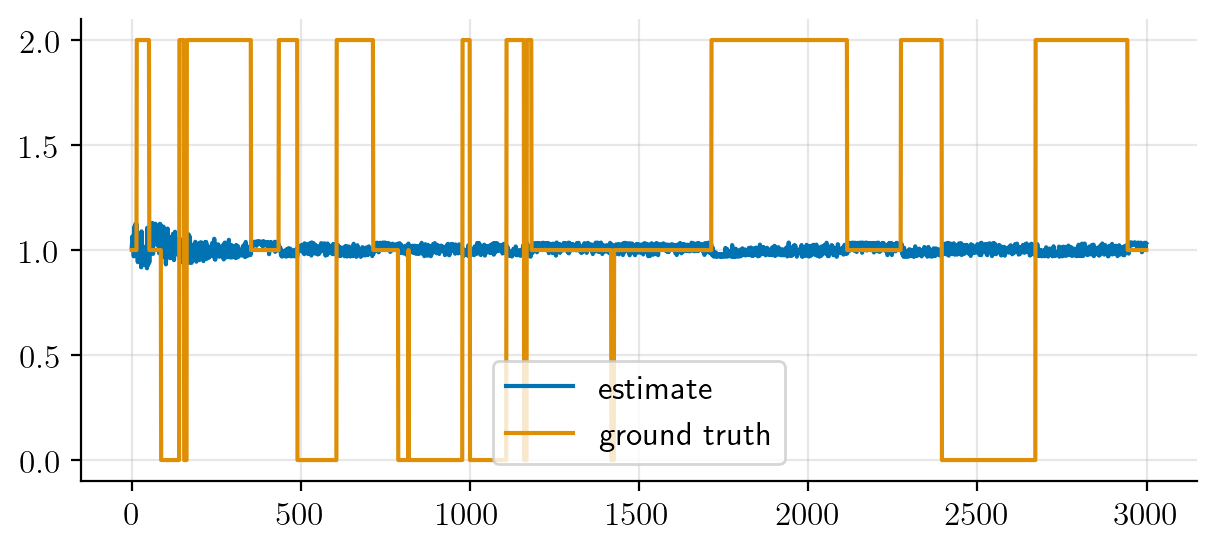

In [946]:
plt.plot(mean_avg, label="estimate")
plt.plot(hist_regime, label="ground truth")
plt.legend()
plt.grid(alpha=0.3)

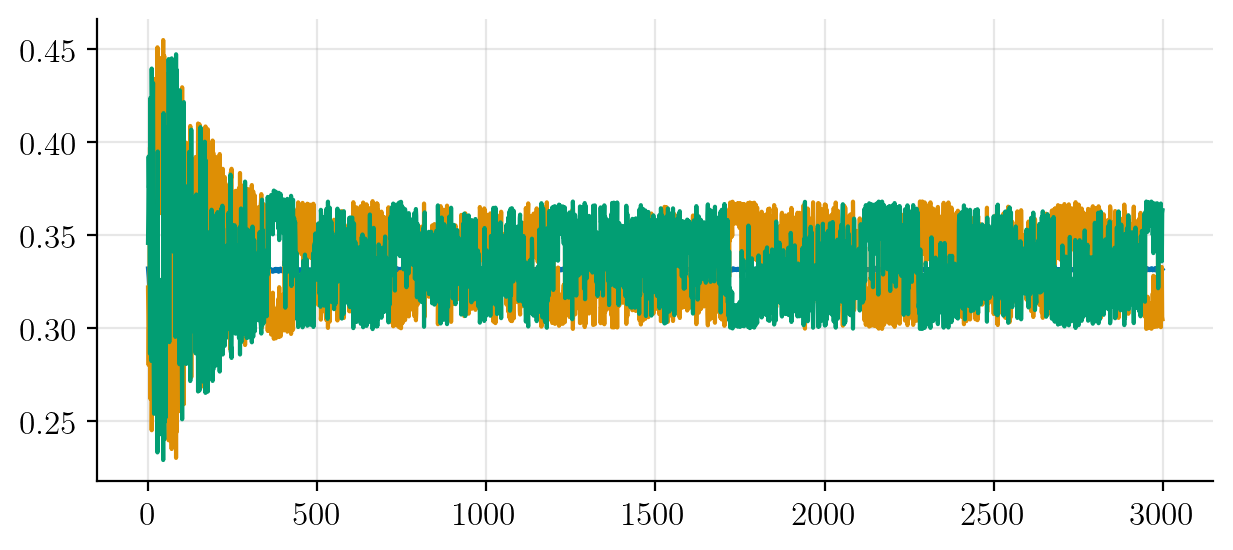

In [947]:
plt.plot(hist_ll)
plt.grid(alpha=0.3)

# RBPF with transition as proposal

In [1024]:
n_particles = 100

In [1025]:
@partial(jax.vmap, in_axes=(0, None, 0, None))
def kf_rbpf_step(key, y, bel, cfg):
    """
    Draw a single sample from proposal p(psi(t) | psi(t,s)),
    update belief and compute log_posterior_predictive
    """
    log_p_transition = log_transition_matrix[bel.regime]
    k_next = jax.random.categorical(key, log_p_transition)
    Bk = B[k_next]
    bel_update, log_pp = kf_step(y, Bk, bel, cfg)
    bel_update = bel_update.replace(regime=k_next)

    return bel_update, log_pp


def step(bel, xs, cfg):
    y, key = xs
    key_propagate, key_resample = jax.random.split(key)
    keys = jax.random.split(key_propagate, n_particles)
    bel_update, log_weights = kf_rbpf_step(keys, y, bel, cfg)
    
    ### Resample step ###
    # Resample indices according to log-likelihood
    indices = jax.random.categorical(key_resample, log_weights, shape=(n_particles,))
    # Update new belief
    bel_update = jax.tree.map(lambda x: x[indices], bel_update)

    return bel_update, (log_weights, bel_update.regime, bel_update.mean)

### Filter

In [1026]:
mean_init = jnp.zeros(4)
cov_init = jnp.eye(4) * 1.0
keys = jax.random.split(key_eval, n_steps)
bel_init = KFState.init(key_train, mean_init, cov_init, n_particles, n_regimes)

Xs = (hist_path, keys)
_step = partial(step, cfg=config)
bel_final, (hist_ll, hist_regimes, hist_mean) = jax.lax.scan(_step, bel_init, Xs)

In [1027]:
log_weight = hist_ll - jax.nn.logsumexp(hist_ll, axis=1, keepdims=True)
weights = jnp.exp(log_weight)

## Evaluating performance

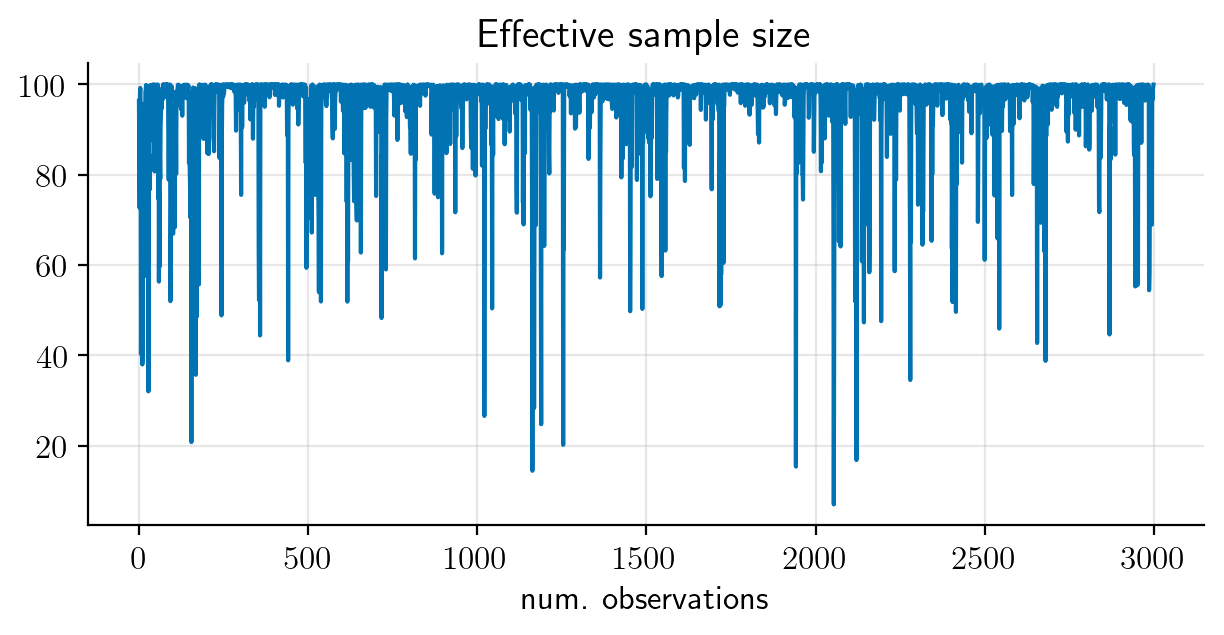

In [1028]:
# Effective sample size
plt.title("Effective sample size")
ess = 1 / jnp.sum(weights ** 2, axis=1)
plt.plot(ess)
plt.xlabel("num. observations")
plt.grid(alpha=0.3)

In [1029]:
ohe_regimes = jax.nn.one_hot(hist_regimes, 3)
weighted_regimes = jnp.einsum("tso,ts->to", ohe_regimes, weights)

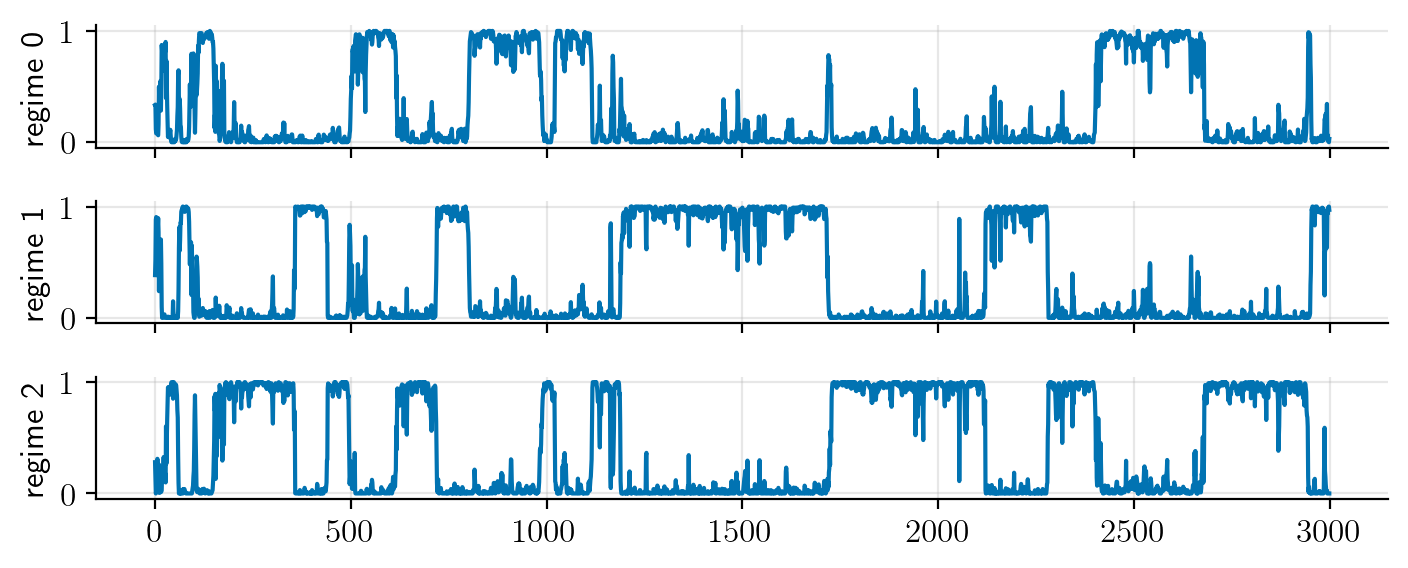

In [1030]:
fig, axs = plt.subplots(3, 1, sharex=True)
for i, ax in enumerate(axs):
    ax.plot(weighted_regimes[:, i])
    ax.set_ylabel(f"regime {i}")
    ax.grid(alpha=0.3)
plt.tight_layout()

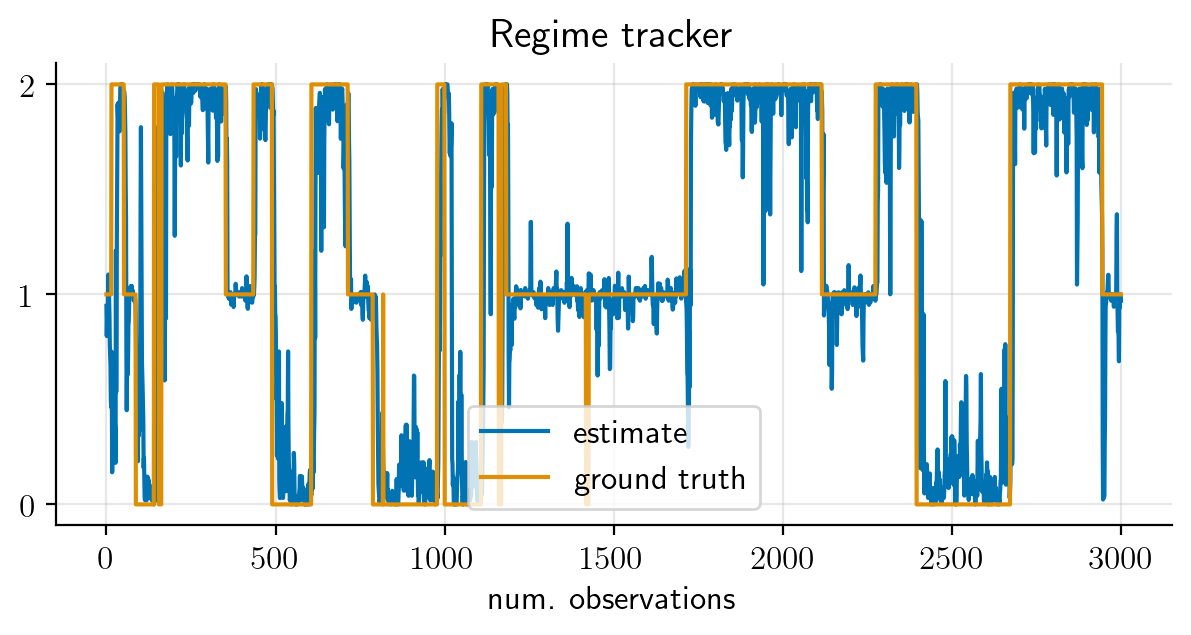

In [1031]:
plt.plot((hist_regimes * weights).sum(axis=1), label="estimate")
plt.plot(hist_regime, label="ground truth")
plt.legend()
plt.yticks([0, 1, 2])
plt.xlabel("")
plt.xlabel("num. observations")
plt.title("Regime tracker")
plt.grid(alpha=0.3)

In [1032]:
hist_mean = jnp.einsum("tsm,ts->tm", hist_mean, weights)

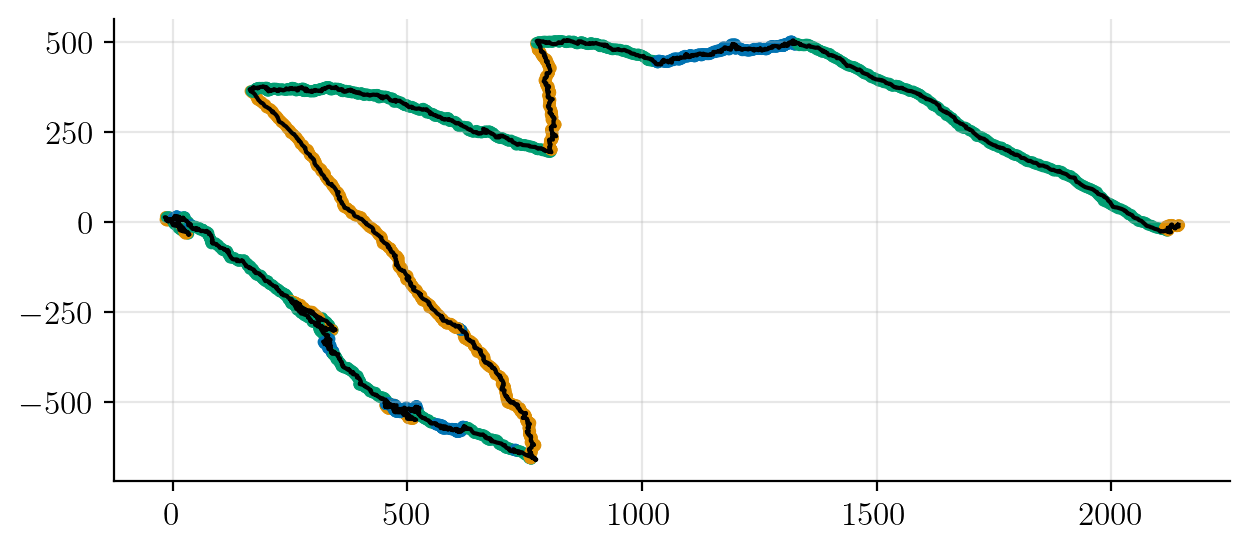

In [1033]:
plt.scatter(hist_latent[:, 0], hist_latent[:, 2], c=colors, s=10)
plt.plot(*hist_mean[:, jnp.array([0, 2])].T, c="black")
plt.grid(alpha=0.3)

## RBPF with optimal proposal

In [1045]:
def multinomial_resampling(key, log_weights, n_particles):
    indices = jax.random.categorical(key, log_weights, shape=(n_particles,))
    return indices

def stratified_resampling(key, log_weights, n_particles):
    """
    TODO: any way to work with log_weight only?
    """
    S = log_weights.shape[0]
    weights = jnp.exp(log_weights)
    cdf = jnp.cumsum(weights)
    # Generate n_particles stratified uniform samples in [0, 1)
    u = (jnp.arange(n_particles) + jax.random.uniform(key, shape=(n_particles,))) / n_particles
    indices = jnp.searchsorted(cdf, u)
    return indices

In [1046]:
@partial(jax.vmap, in_axes=(None, 0, None))
def kf_rbpf_step_optimal(y, bel, cfg):
    log_p_transition = log_transition_matrix[bel.regime]
    regimes = jnp.arange(n_regimes)
    bel_update, log_pp = vkf_step_B(y, B, bel, cfg)
    bel_update = bel_update.replace(regime=regimes)

    log_weight = log_pp + log_p_transition
    return bel_update, log_weight


def flatten_particles(tree):
    """
    Given any pytree with leaf shapes (particles options ...),
    we stack the leaf to be (particle options) ...
    """
    einops_expr = "particles options ... -> (particles options) ..."
    res = jax.tree.map(lambda x: einops.rearrange(x, einops_expr), tree)
    return res


def step_optimal(bel, xs, cfg):
    y, key = xs
    bel_update, log_weights = kf_rbpf_step_optimal(y, bel, cfg)

    bel_update, log_weights = flatten_particles((bel_update, log_weights))

    log_weights = log_weights - jax.nn.logsumexp(log_weights)
    weights = jnp.exp(log_weights)
    mean_position = (bel_update.mean * weights[:, None]).sum(axis=0)
    regimes = bel_update.regime
    
    # Resample step: from S * num_regimes -> S
    
    # Resample indices according to log-weights
    # new_ixs = stratified_resampling(key, log_weights, n_particles)
    new_ixs = multinomial_resampling(key, log_weights, n_particles)
    # Update new belief
    bel_update = jax.tree.map(lambda x: x[new_ixs], bel_update)

    return bel_update, (log_weights, mean_position, regimes)

### Filter

In [1047]:
n_particles = 200
n_regimes = 3

In [1048]:
key_init, key_eval = jax.random.split(key_train)

In [1049]:
%%time
mean_init = jnp.zeros(4)
cov_init = jnp.eye(4) * 2.0
keys = jax.random.split(key_eval, n_steps)
bel_init = KFState.init(key_train, mean_init, cov_init, n_particles, n_regimes)

Xs = (hist_path, keys)
_step = partial(step_optimal, cfg=config)
bel_final, (hist_ll, hist_mean, hist_regimes) = jax.lax.scan(_step, bel_init, Xs)

CPU times: user 7.12 s, sys: 1.91 s, total: 9.03 s
Wall time: 6.2 s


In [1050]:
log_weight = hist_ll - jax.nn.logsumexp(hist_ll, axis=1, keepdims=True)
weights = jnp.exp(log_weight)

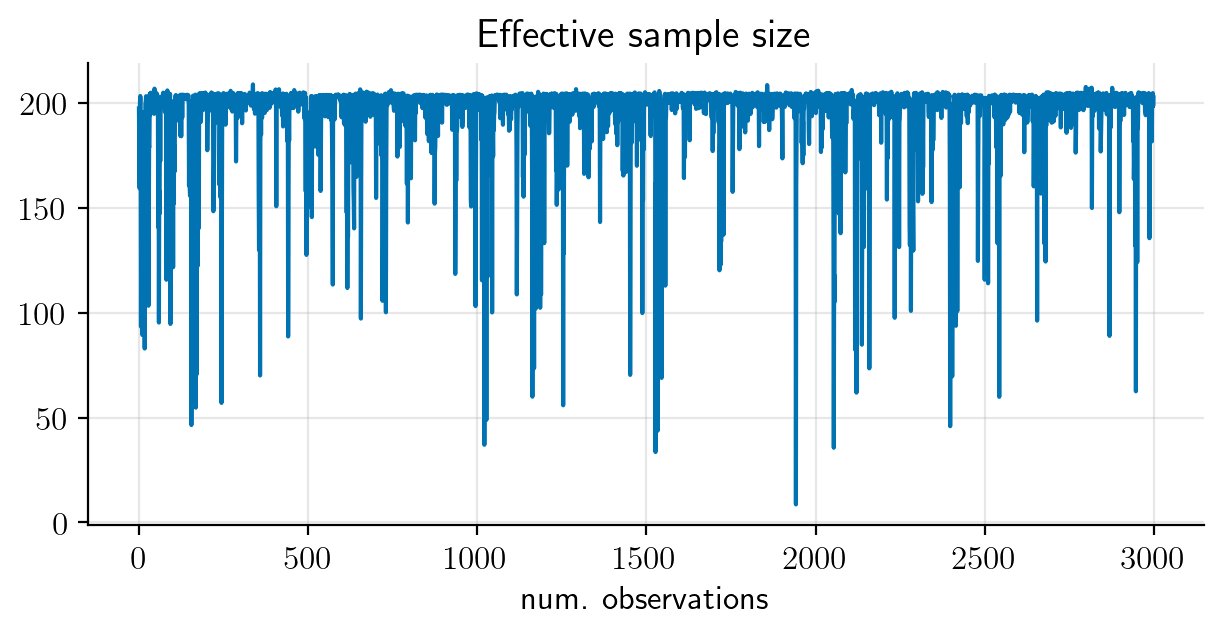

In [1051]:
# Effective sample size
plt.title("Effective sample size")
ess = 1 / jnp.sum(weights ** 2, axis=1)
plt.plot(ess)
plt.xlabel("num. observations")
plt.grid(alpha=0.3)

In [1052]:
ohe_regimes = jax.nn.one_hot(hist_regimes, 3)
weighted_regimes = jnp.einsum("tso,ts->to", ohe_regimes, weights)

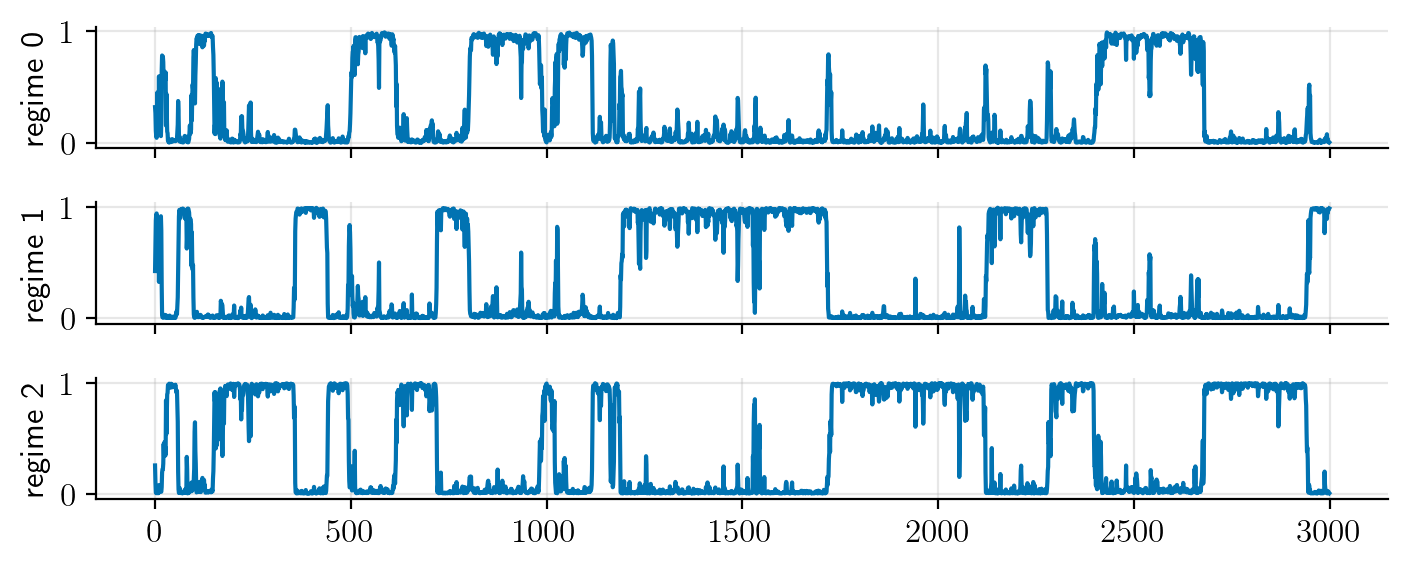

In [1053]:
fig, axs = plt.subplots(3, 1, sharex=True)
for i, ax in enumerate(axs):
    ax.plot(weighted_regimes[:, i])
    ax.set_ylabel(f"regime {i}")
    ax.grid(alpha=0.3)
plt.tight_layout()

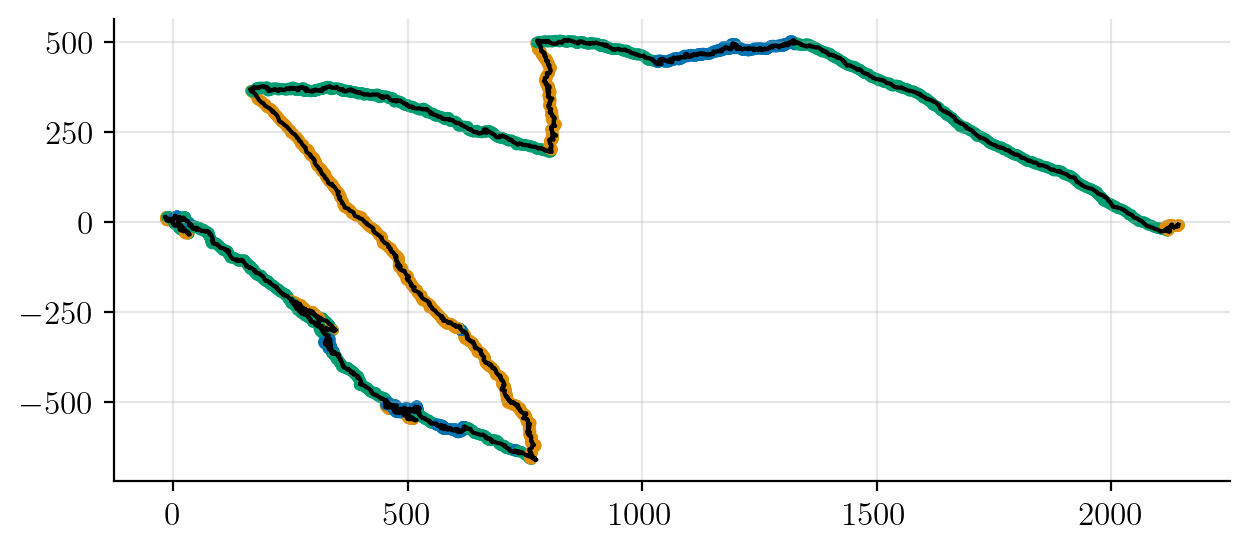

In [1054]:
plt.scatter(hist_latent[:, 0], hist_latent[:, 2], c=colors, s=10)
plt.plot(*hist_mean[:, jnp.array([0, 2])].T, c="black")
plt.grid(alpha=0.3)

---

# RBPF with empirical transition as proposal

In [1496]:
@chex.dataclass
class KFMkvState:
    """
    Kalman filter with empirical Markov transition matrix
    """
    mean: jax.Array
    cov: jax.Array
    regime: jax.Array # KF config
    count_matrix: jax.Array

    @staticmethod
    def init(key, mean, cov, n_particles, n_configs):
        means = einops.repeat(mean, "m -> s m", s=n_particles)
        covs = einops.repeat(cov, "i j -> s i j", s=n_particles)

        key_regimes, key_count = jax.random.split(key)
        regimes = jax.random.choice(key, n_configs, (n_particles,)) # uniform sample over configs

        # count_matrix = jnp.ones((n_regimes, n_regimes)) * 1
        count_matrix = jax.vmap(jnp.diag)(jnp.ones((n_particles, n_regimes))) * 15.0
        # count_matrix = jax.vmap(jnp.diag)(jax.random.choice(key, 10, (n_particles, n_regimes))) * 1.0
        
        return KFMkvState(
            mean=means, 
            cov=covs,
            regime=regimes,
            count_matrix=count_matrix,
        )

In [1497]:
n_particles = 20

In [1498]:
def multinomial_resampling(key, log_weights, n_particles):
    indices = jax.random.categorical(key, log_weights, shape=(n_particles,))
    return indices

def stratified_resampling(key, log_weights, n_particles):
    """
    TODO: any way to work with log_weight only?
    """
    S = log_weights.shape[0]
    weights = jnp.exp(log_weights)
    cdf = jnp.cumsum(weights)
    # Generate n_particles stratified uniform samples in [0, 1)
    u = (jnp.arange(n_particles) + jax.random.uniform(key, shape=(n_particles,))) / n_particles
    indices = jnp.searchsorted(cdf, u)
    return indices

In [1499]:
@partial(jax.vmap, in_axes=(None, 0, None))
def kf_rbpf_step_optimal(y, bel, cfg):
    log_p_transition = jnp.log1p(bel.count_matrix[bel.regime])
    log_p_transition = log_p_transition - jnp.log1p(bel.count_matrix[bel.regime].sum())
    
    regimes = jnp.arange(n_regimes)
    bel_update, log_pp = vkf_step_B(y, B, bel, cfg)
    bel_update = bel_update.replace(regime=regimes)

    log_weight = log_pp + log_p_transition

    ix_configs = regimes
    ix_bel = jnp.repeat(bel.regime, n_regimes)
    ix_next = regimes
    
    new_count =  bel_update.count_matrix[ix_configs, ix_bel, ix_next] + 1.0
    count_matrix_update = bel_update.count_matrix.at[ix_configs, ix_bel, ix_next].set(new_count)
    bel_update = bel_update.replace(
        count_matrix=count_matrix_update,
    )
        
    return bel_update, log_weight


def flatten_particles(tree):
    """
    Given any pytree with leaf shapes (particles options ...),
    we stack the leaf to be (particle options) ...
    """
    einops_expr = "particles options ... -> (particles options) ..."
    res = jax.tree.map(lambda x: einops.rearrange(x, einops_expr), tree)
    return res


def step_optimal(bel, xs, cfg):
    y, key = xs
    bel_update, log_weights = kf_rbpf_step_optimal(y, bel, cfg)
    bel_update, log_weights = flatten_particles((bel_update, log_weights))

    log_weights = log_weights - jax.nn.logsumexp(log_weights)
    weights = jnp.exp(log_weights)
    mean_position = (bel_update.mean * weights[:, None]).sum(axis=0)
    regimes = bel_update.regime
    
    # Resample step: from S * num_regimes -> S
    
    # Resample indices according to log-weights
    new_ixs = stratified_resampling(key, log_weights, n_particles)
    # new_ixs = multinomial_resampling(key, log_weights, n_particles)
    # Update new belief
    bel_update = jax.tree.map(lambda x: x[new_ixs], bel_update)

    return bel_update, (log_weights, mean_position, regimes)

### Filter

In [1500]:
n_particles = 20
n_regimes = 3

In [1501]:
key_init, key_eval = jax.random.split(key_train)

In [1502]:
keys = jax.random.split(key_eval, n_steps)

In [1503]:
%%time
mean_init = jnp.zeros(4)
cov_init = jnp.eye(4) * 1.0
keys = jax.random.split(key_eval, n_steps)
bel_init = KFMkvState.init(key_train, mean_init, cov_init, n_particles, n_regimes)

Xs = (hist_path, keys)
_step = partial(step_optimal, cfg=config)
bel_final, (hist_ll, hist_mean, hist_regimes) = jax.lax.scan(_step, bel_init, Xs)

CPU times: user 472 ms, sys: 61.7 ms, total: 534 ms
Wall time: 568 ms


In [1504]:
(bel_final.count_matrix / bel_final.count_matrix.sum(axis=1, keepdims=True)).mean(axis=0)

Array([[0.9701168 , 0.00576232, 0.01093694],
       [0.01451008, 0.98470706, 0.00364564],
       [0.01537287, 0.00953078, 0.9854175 ]], dtype=float32)

In [1505]:
log_weight = hist_ll - jax.nn.logsumexp(hist_ll, axis=1, keepdims=True)
weights = jnp.exp(log_weight)

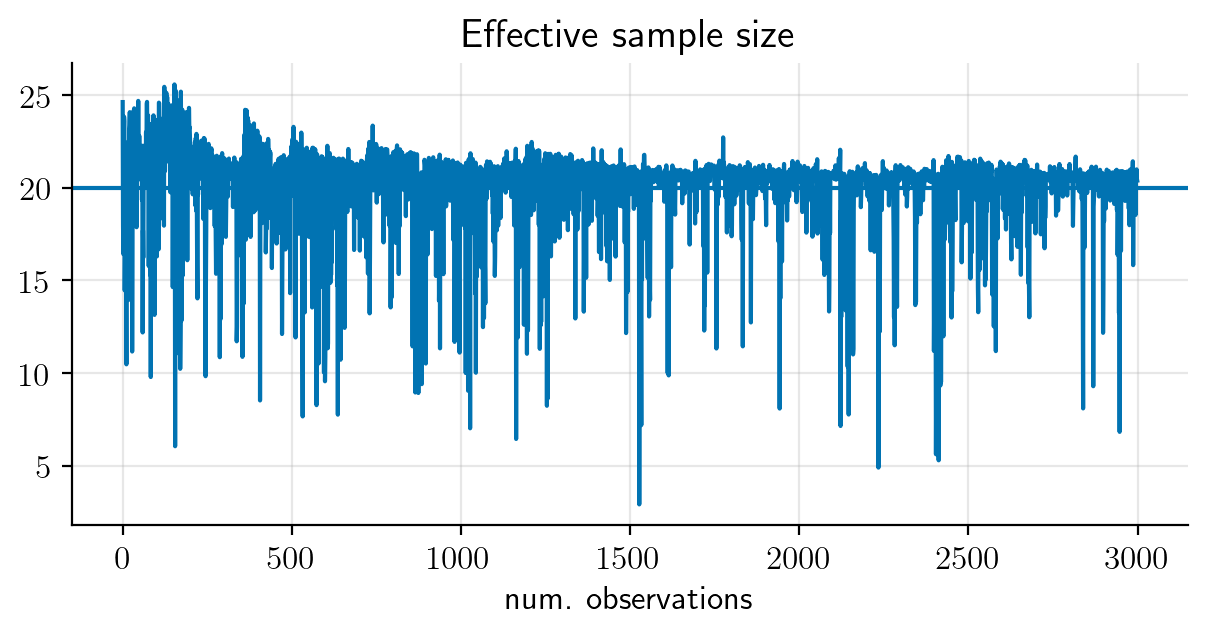

In [1506]:
# Effective sample size
plt.title("Effective sample size")
plt.axhline(y=n_particles)
ess = 1 / jnp.sum(weights ** 2, axis=1)
plt.plot(ess)
plt.xlabel("num. observations")
plt.grid(alpha=0.3)

In [1507]:
ohe_regimes = jax.nn.one_hot(hist_regimes, 3)
weighted_regimes = jnp.einsum("tso,ts->to", ohe_regimes, weights)

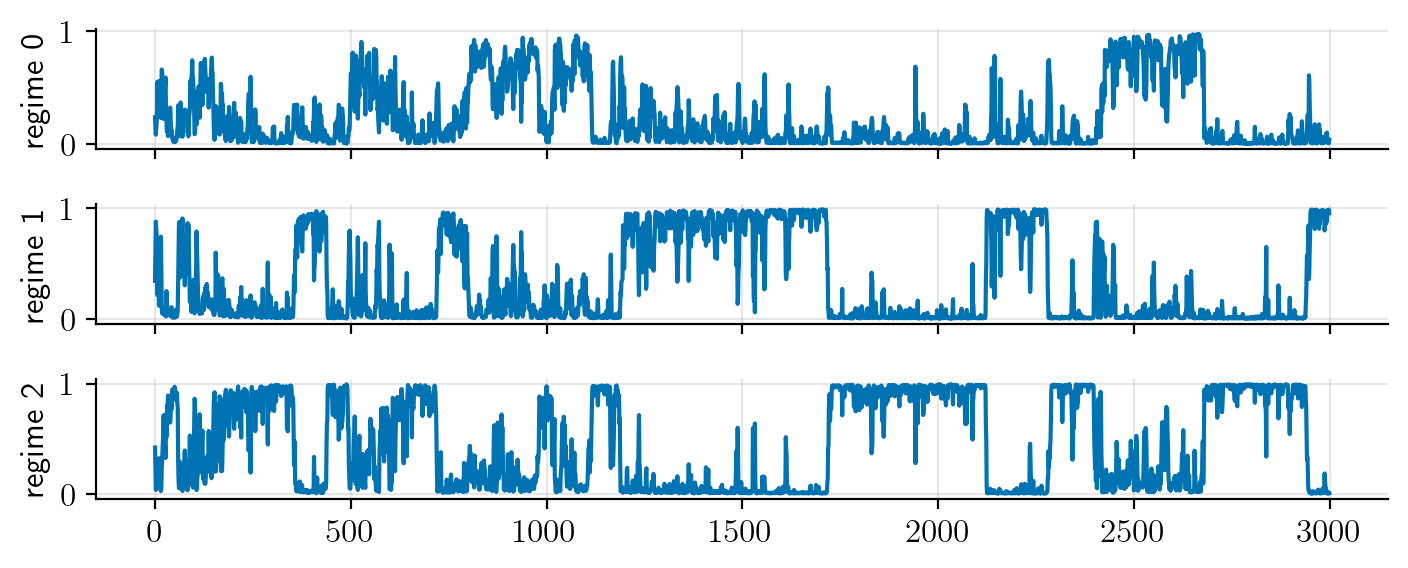

In [1508]:
fig, axs = plt.subplots(3, 1, sharex=True)
for i, ax in enumerate(axs):
    ax.plot(weighted_regimes[:, i])
    ax.set_ylabel(f"regime {i}")
    ax.grid(alpha=0.3)
plt.tight_layout()

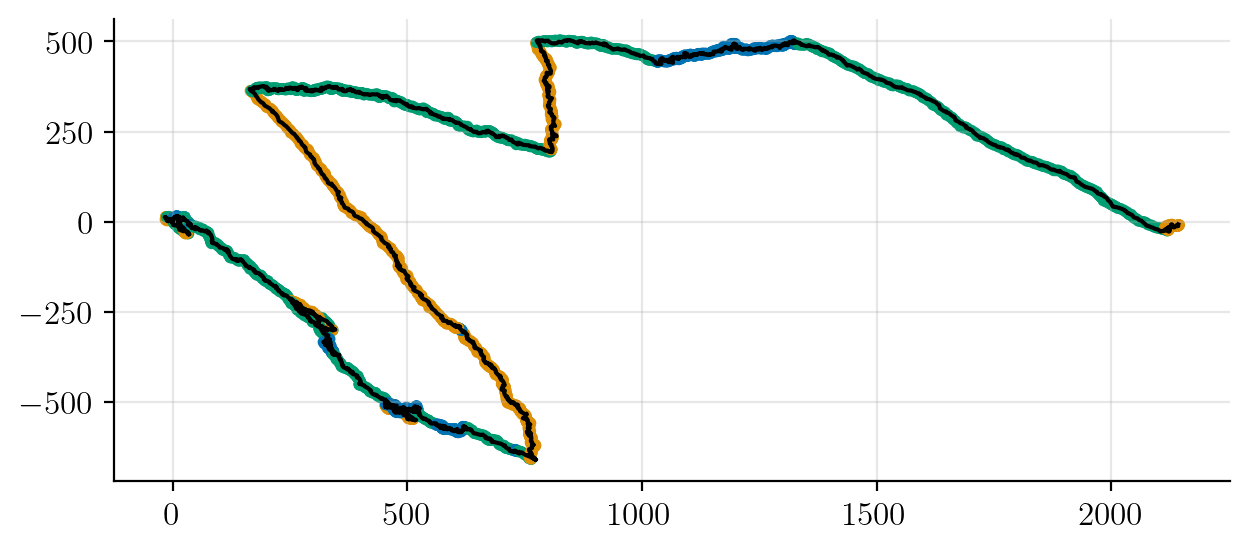

In [1509]:
plt.scatter(hist_latent[:, 0], hist_latent[:, 2], c=colors, s=10)
plt.plot(*hist_mean[:, jnp.array([0, 2])].T, c="black")
plt.grid(alpha=0.3)

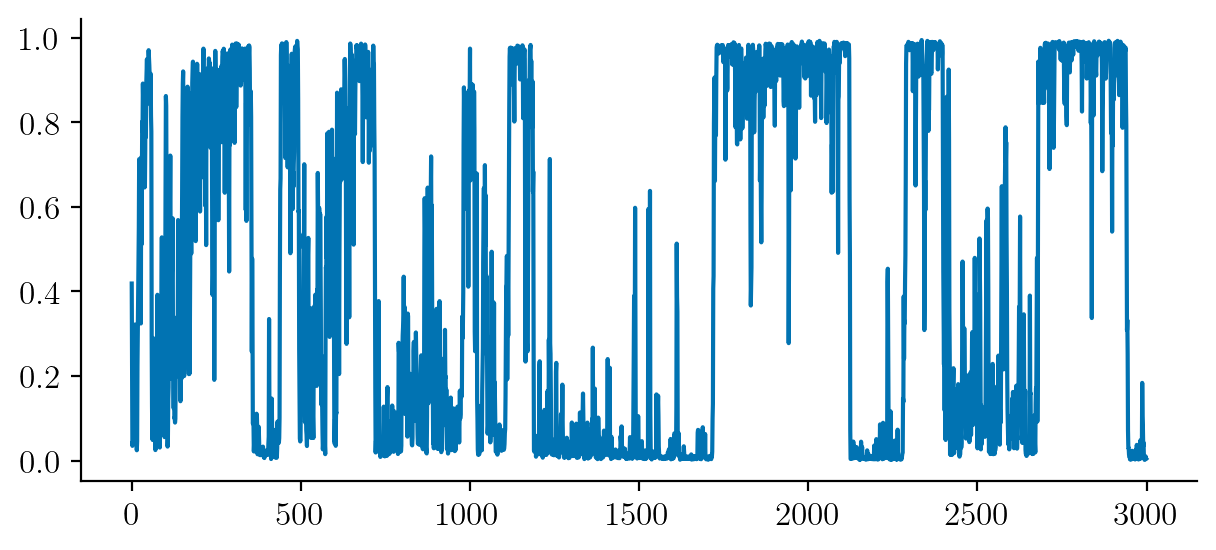

In [1510]:
plt.plot(weighted_regimes[:, 2])

In [1511]:
(weighted_regimes * jnp.arange(3)).sum(axis=1)

Array([1.1814634 , 1.1114275 , 0.9503312 , ..., 0.9953028 , 0.99475944, 0.9644336 ], dtype=float32)

In [1512]:
jnp.arange(3)

Array([0, 1, 2], dtype=int32)

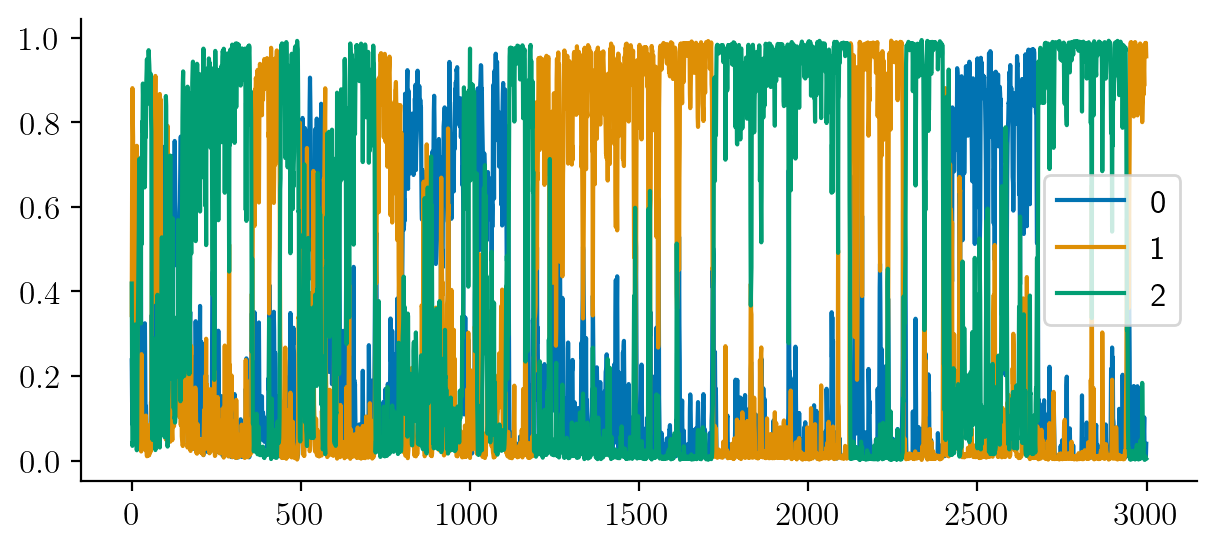

In [1513]:
plt.plot(weighted_regimes, label=jnp.arange(3))
plt.legend()

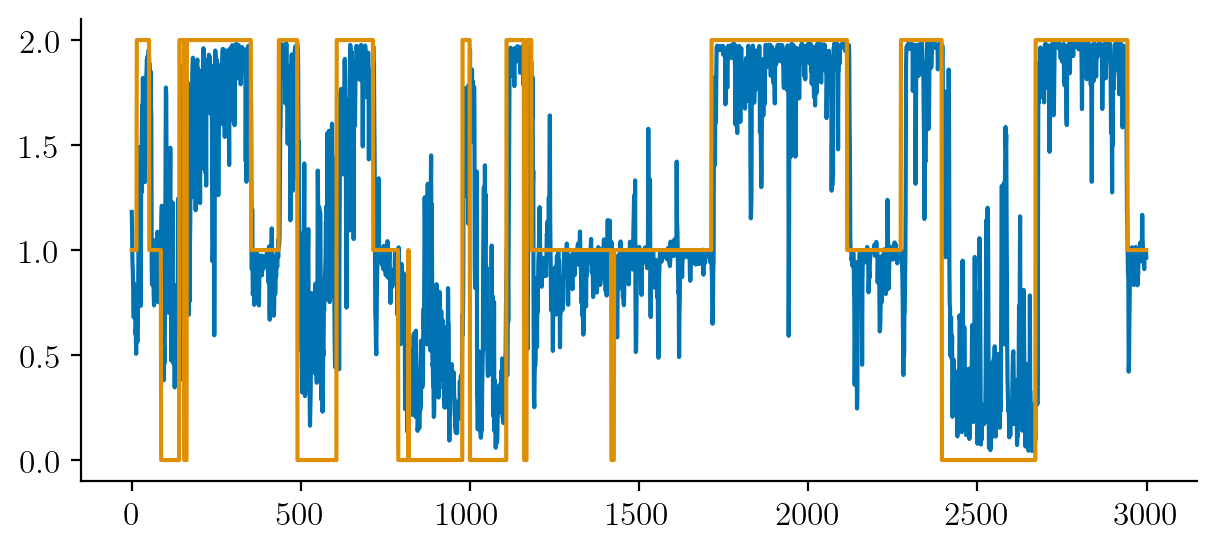

In [1514]:
plt.plot((weighted_regimes * jnp.arange(3)).sum(axis=1))
plt.plot(hist_regime)